# To include supervised ML, I'll try to build a model to predict vote averages using Random Forest 

In [161]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
import ast
from sklearn.decomposition import PCA
import pickle
import joblib
import seaborn as sns


In [162]:
movies = pd.read_csv('../data/movies_dataset.csv')

In [163]:
# Convert columns from string to list
for col in ['genres', 'top_cast', 'keywords']:
    movies[col] = movies[col].apply(ast.literal_eval)

In [164]:
movies.head(1)

,budget,id,original_language,revenue,runtime,title,vote_average,vote_count,top_cast,director,genres,keywords,release_year,profit,decade
0,30000000.0,862,en,373554033.0,81.0,Toy Story,7.7,5415.0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",John Lasseter,"[Animation, Comedy, Family]","[jealousy, toy, boy, friendship, friends, riva...",1995,343554033.0,1990


In [165]:
# Limiting features before encoding
# Keywords - limiting to 100 
all_keywords = pd.Series([kw for kws in movies['keywords'] for kw in kws])
top_keywords = all_keywords.value_counts().head(100).index
movies['keywords'] = movies['keywords'].apply(lambda kws: [kw for kw in kws if kw in top_keywords])

# Actors - limiting to 100
all_actors = pd.Series([actor for cast in movies['top_cast'] for actor in cast])
top_actors = all_actors.value_counts().head(100).index
movies['top_cast'] = movies['top_cast'].apply(lambda cast: [actor for actor in cast if actor in top_actors])

# Directors - limiting to 50
top_directors = movies['director'].value_counts().head(50).index
movies['director'] = movies['director'].apply(lambda d: d if d in top_directors else 'Other')

# I will be skipping genres as they are already limited


In [166]:
# Encoding features
# Genres
mlb_genres = MultiLabelBinarizer()
genres_encoded = mlb_genres.fit_transform(movies['genres'])

# Keywords
mlb_keywords = MultiLabelBinarizer()
keywords_encoded = mlb_keywords.fit_transform(movies['keywords'])

# Top Cast
mlb_cast = MultiLabelBinarizer()
cast_encoded = mlb_cast.fit_transform(movies['top_cast'])

# Director (one-hot)
director_encoded = pd.get_dummies(movies['director']).values

# Language (one-hot)
language_encoded = pd.get_dummies(movies['original_language']).values


In [167]:
# Scaling features using StandardScaler
num_features = ['budget', 'revenue', 'runtime', 'profit', 'release_year']
scaler = StandardScaler()
num_encoded = scaler.fit_transform(movies[num_features])

In [168]:
X = np.hstack([
    genres_encoded,
    keywords_encoded,
    cast_encoded,
    director_encoded,
    language_encoded,
    num_encoded 
])

In [169]:
# First I'll convert continuous ratings to categories to be used with RandomForestClassifier
def categorize_ratings(rating):
    if rating > 7:
        return 'Good'
    elif rating >= 5:
        return 'Average'
    else:
        return 'Poor'

In [170]:
# Creating categorical target variable to use for my dependent variable
movies['rating_category'] = movies['vote_average'].apply(categorize_ratings)
y = movies['rating_category']

In [171]:
print(movies['rating_category'].value_counts())

rating_category
Average    3723
Good        921
Poor        296
Name: count, dtype: int64


In [172]:
# Splitting the data into training and test sets
size = 0.25
seed = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=size, random_state=seed, stratify=y
)

print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

Train set: (3705, 312), Test set: (1235, 312)


In [173]:
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    random_state=7,
    class_weight='balanced'
)

rf_classifier.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=15, random_state=7)

In [174]:
# Predict using the test set
rf_y_pred = rf_classifier.predict(X_test)

# Accuracy
rf_acc = accuracy_score(y_test, rf_y_pred)
print(f"Random Forest Accuracy: {rf_acc:.4f}")

# Confusion Matrix
rf_cm = confusion_matrix(y_test, rf_y_pred)
print("Random Forest Confusion Matrix:")
print(rf_cm)

# Classification Report
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_y_pred))

Random Forest Accuracy: 0.7036
Random Forest Confusion Matrix:
[[734 106  91]
 [118 109   3]
 [ 47   1  26]]
Random Forest Classification Report:
              precision    recall  f1-score   support

     Average       0.82      0.79      0.80       931
        Good       0.50      0.47      0.49       230
        Poor       0.22      0.35      0.27        74

    accuracy                           0.70      1235
   macro avg       0.51      0.54      0.52      1235
weighted avg       0.72      0.70      0.71      1235



In [175]:
# Cross-validation for Random Forest
rf_cv_scores = cross_val_score(rf_classifier, X, y, cv=5, scoring='accuracy')
print(f"Random Forest CV scores: {rf_cv_scores}")
print(f"Random Forest Mean CV accuracy: {rf_cv_scores.mean():.4f}")

Random Forest CV scores: [0.61032389 0.64878543 0.66295547 0.69433198 0.71255061]
Random Forest Mean CV accuracy: 0.6658


In [176]:
# Get feature names for each encoded part
genre_names = [f"genre_{g}" for g in mlb_genres.classes_]
keyword_names = [f"keyword_{k}" for k in mlb_keywords.classes_]
cast_names = [f"cast_{c}" for c in mlb_cast.classes_]
director_names = [f"director_{d}" for d in pd.get_dummies(movies['director']).columns]
language_names = [f"lang_{l}" for l in pd.get_dummies(movies['original_language']).columns]
num_names = num_features  # already defined

# Combine all feature names in the same order as np.hstack
all_feature_names = (
    genre_names
    + keyword_names
    + cast_names
    + director_names
    + language_names
    + num_names
)


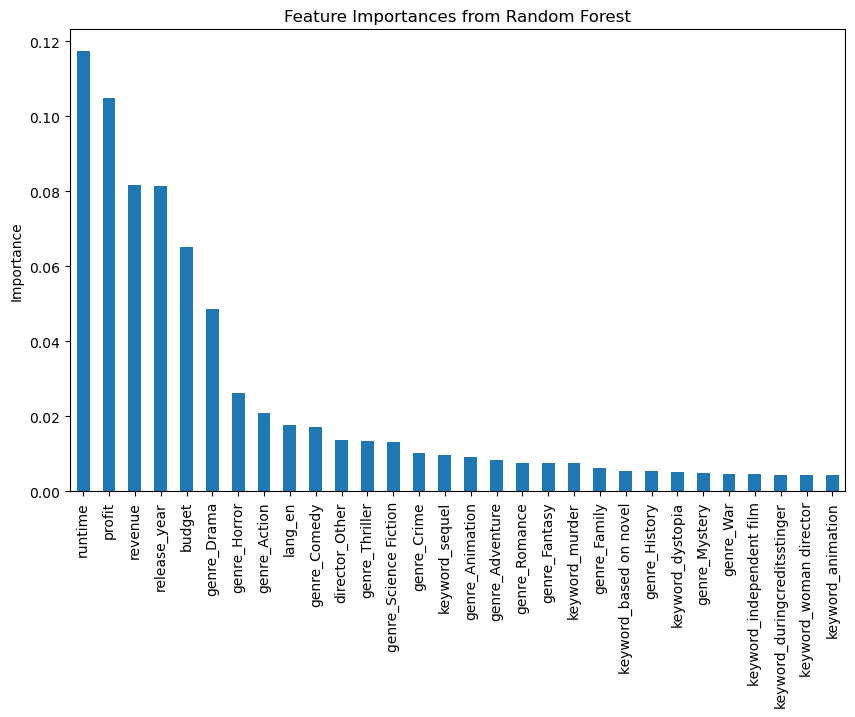

In [ ]:
rf_importances = pd.Series(
    rf_classifier.feature_importances_,
    index=all_feature_names
)
rf_importances = rf_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
rf_importances.head(30).plot(kind='bar') 
plt.title('Feature Importances from Random Forest')
plt.ylabel('Importance')
plt.show()


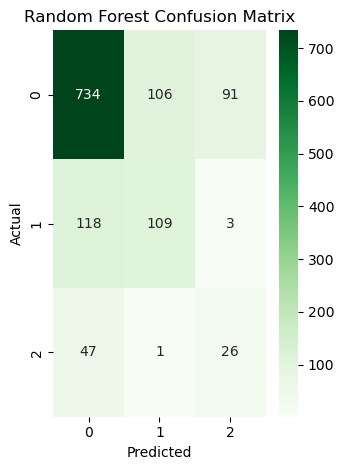

In [178]:
plt.subplot(1, 2, 2)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Greens')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()